### 1. Setting up the initial environment

In [9]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

In [10]:
import sys
import subprocess
import pkg_resources
from collections import Counter
import re
import os

required = {'spacy', 'scikit-learn', 'numpy', 'pandas', 'torch', 'wordcloud', 'transformers'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

print(missing)

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

import spacy
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
import pickle
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
import transformers

from spacy.lang.en import English
!python -m spacy download en_core_web_md
import en_core_web_md
nlp = en_core_web_md.load()
en = English()

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

set()
2023-05-09 15:25:02.367249: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import string

In [42]:
device = torch.device("cpu")

### 2. Feature Engineering 

In [13]:
def simple_tokenizer(doc, model=en):
    # a simple tokenizer for individual documents (different from above)
    tokenized_docs = []
    parsed = model(doc)
    return([t.lower_ for t in parsed if (t.is_alpha)&(not t.like_url)&(not t.is_stop)])
STOPLIST = spacy.lang.en.stop_words.STOP_WORDS
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "_ _","--","...", "”", "”"]


class CleanTextTransformer(TransformerMixin):
   def transform(self, X, **transform_params):
        return [cleanText(text) for text in X]
   def fit(self, X, y=None, **fit_params):
        return self
def get_params(self, deep=True):
        return {}
    
def cleanText(text):
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = text.lower()
    return text

In [14]:
STOPLIST = spacy.lang.en.stop_words.STOP_WORDS
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-", "_ _","--","...", "”", "”"]


class CleanTextTransformer(TransformerMixin):
   def transform(self, X, **transform_params):
        return [cleanText(text) for text in X]
   def fit(self, X, y=None, **fit_params):
        return self
def get_params(self, deep=True):
        return {}
    
def cleanText(text):
    text = text.strip().replace("\n", " ").replace("\r", " ")
    text = text.lower()
    return text

### 3. Exploring the Dataset

In [15]:
artistLyricsDF = pd.read_csv('lyrics_all_combined.csv')
#artistLyricsDF.head()
#artistLyricsDF.info()

tcc_lyrics = pd.read_csv('tcc_ceds_music.csv')
tcc_lyrics.info()
tcc_lyrics.head()
tcc_lyrics.columns



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28372 entries, 0 to 28371
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                28372 non-null  int64  
 1   artist_name               28372 non-null  object 
 2   track_name                28372 non-null  object 
 3   release_date              28372 non-null  int64  
 4   genre                     28372 non-null  object 
 5   lyrics                    28372 non-null  object 
 6   len                       28372 non-null  int64  
 7   dating                    28372 non-null  float64
 8   violence                  28372 non-null  float64
 9   world/life                28372 non-null  float64
 10  night/time                28372 non-null  float64
 11  shake the audience        28372 non-null  float64
 12  family/gospel             28372 non-null  float64
 13  romantic                  28372 non-null  float64
 14  commun

Index(['Unnamed: 0', 'artist_name', 'track_name', 'release_date', 'genre',
       'lyrics', 'len', 'dating', 'violence', 'world/life', 'night/time',
       'shake the audience', 'family/gospel', 'romantic', 'communication',
       'obscene', 'music', 'movement/places', 'light/visual perceptions',
       'family/spiritual', 'like/girls', 'sadness', 'feelings', 'danceability',
       'loudness', 'acousticness', 'instrumentalness', 'valence', 'energy',
       'topic', 'age'],
      dtype='object')

Text(0.5, 1.0, 'Total Count across Genres')

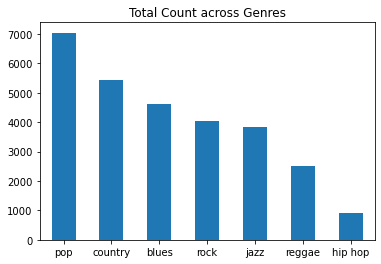

In [52]:
tcc_lyrics.genre.value_counts().plot.bar(rot=0)
plt.title('Total Count across Genres')

Text(0.5, 1.0, 'Distributed genres after trimming and filtering')

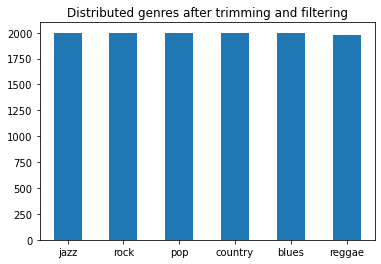

In [53]:
artistLyricsDF.genre.value_counts().plot.bar(rot=0)
plt.title("Distributed genres after trimming and filtering")

In [18]:

aldf = artistLyricsDF[['artist_name', 'track_name', 'lyrics', 'genre']]
aldf.info()

finalDF = aldf[aldf.lyrics.notnull()]
finalDF.info()

artists = finalDF['artist_name'].unique()
genres = finalDF['genre'].unique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11978 entries, 0 to 11977
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   artist_name  11978 non-null  object
 1   track_name   11978 non-null  object
 2   lyrics       11978 non-null  object
 3   genre        11978 non-null  object
dtypes: object(4)
memory usage: 374.4+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11978 entries, 0 to 11977
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   artist_name  11978 non-null  object
 1   track_name   11978 non-null  object
 2   lyrics       11978 non-null  object
 3   genre        11978 non-null  object
dtypes: object(4)
memory usage: 467.9+ KB


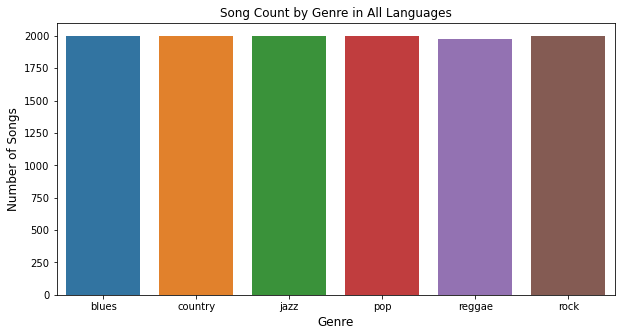

In [19]:
plt.figure(figsize=(10,5))

sns.countplot(x='genre', data=finalDF)

plt.title('Song Count by Genre in All Languages')
plt.ylabel('Number of Songs', fontsize=12)
plt.xlabel('Genre', fontsize=12)
plt.show()

### 4. Data Preparation

In [20]:
genreLabels=[]

for x in finalDF['genre'].tolist():
    if x == 'blues':
        y = True
    else:
        y = False
    genreLabels.append(y)

is_blues = np.array(genreLabels)

In [21]:
finalDF.rename(columns = {'artist_name':'Artist', 'track_name':'SName','genre':'Genre','lyrics':'Lyric'}, inplace = True)

Artists = finalDF['Artist'].unique()
Genres = finalDF['Genre'].unique()

df = pd.DataFrame(columns=('artist', 'words', 'songcount'))
j=0

tokens =[]
for artist in Artists:
    num_words = 0
    lyrics = finalDF['Lyric'][finalDF['Artist'] == artist]
    #print("\nArtist %s" %artist, "Num Lyrics %s" %len(lyrics))
    for lyric in lyrics:
        #print("\nArtist %s" %artist,"Lyric:\n" , lyric)
        words = simple_tokenizer(lyric)
        tokens.append(words)
        num_words = num_words + len(words)
    df.loc[j] = (artist, num_words, len(lyrics))
    j+=1
    i=0

### 5. Data Visualisation

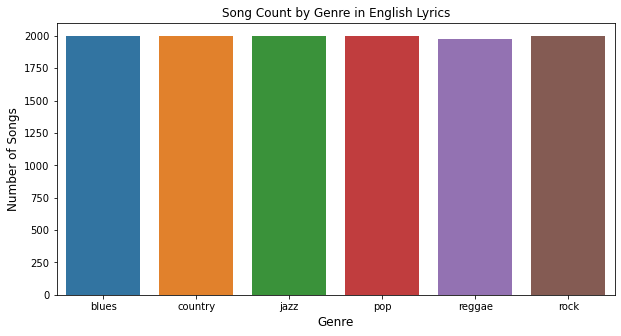

In [22]:
plt.figure(figsize=(10,5))

sns.countplot(x='Genre', data=finalDF)

plt.title('Song Count by Genre in English Lyrics')
plt.ylabel('Number of Songs', fontsize=12)
plt.xlabel('Genre', fontsize=12)
plt.show()


In [23]:
df.head()

,artist,words,songcount
0,santana,2009,19
1,marvin sease,558,3
2,the robert cray band,330,3
3,carl sims,193,1
4,rufus thomas,431,4


/Users/holys/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


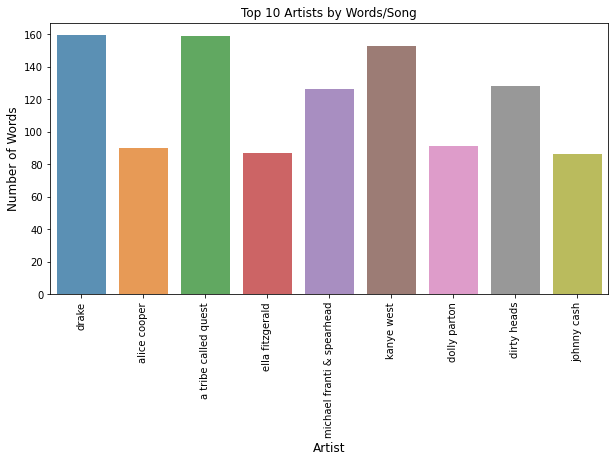

In [24]:
sort_df = df.sort_values('words',ascending=False)
sort_df = sort_df.iloc[0:9,]

plt.figure(figsize=(10,5))
sns.barplot((sort_df.artist), (sort_df.words/sort_df.songcount), alpha=0.8)
plt.title('Top 10 Artists by Words/Song')
plt.ylabel('Number of Words', fontsize=12)
plt.xlabel('Artist', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [25]:
finalDF.columns

Index(['Artist', 'SName', 'Lyric', 'Genre'], dtype='object')

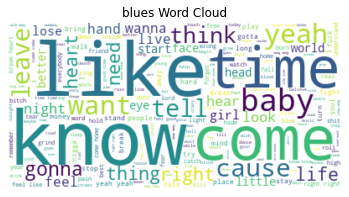

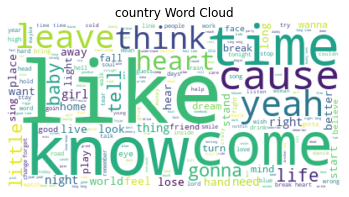

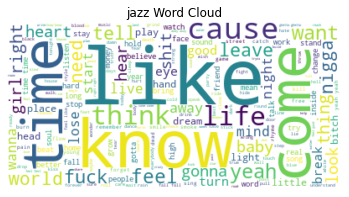

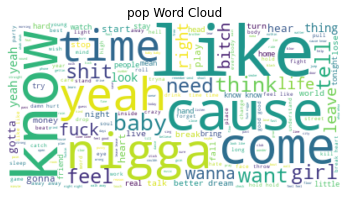

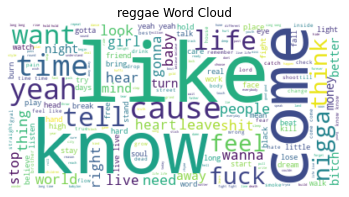

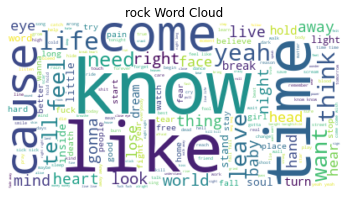

In [54]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline



grid = plt.GridSpec(1, 6, wspace=0.4, hspace=0.3)

for i in range(0, 6):
    #plt.subplot(grid[0,i])    #2, 2, i+1)
    lyric = " ".join(lyric for lyric in finalDF[finalDF['Genre']== genres[i]].Lyric)
    wordcloud = WordCloud(stopwords=STOPLIST, background_color="white").generate(lyric)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(genres[i] + " Word Cloud")
    plt.axis("off")
    plt.show()

In [28]:
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [29]:
cv = CountVectorizer(tokenizer=simple_tokenizer, lowercase=False, min_df=0.01, max_df=0.9)
tfidf = TfidfVectorizer(tokenizer=simple_tokenizer, lowercase=False, min_df=0.01, max_df=0.9)

# get vectors
count_vecs = cv.fit_transform(finalDF['Lyric']).toarray()
lyric_features = tfidf.fit_transform(finalDF['Lyric']).toarray()

/Users/holys/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### 6. Topic Modeling

In [30]:
n_topics = 10
n_words = 10

# LDA uses word counts
lda = LatentDirichletAllocation(n_components=n_topics, n_jobs=-1)
lda_lyric_features = lda.fit_transform(count_vecs)

# Print the topics found by the LDA model
print("\n Topics found via LDA:")
print_topics(lda, cv, n_words)


 Topics found via LDA:

Topic #0:
hold got ta believe hand sweet love head fool comin

Topic #1:
yeah play music somebody ready bring smoke sound follow dance

Topic #2:
time wanna know mind cause like bout think stop real

Topic #3:
sing long song hear blue come world kiss dream lonely

Topic #4:
black home cold hell save come fight devil lord soul

Topic #5:
na gon come kill dead head blood stand shoot hear

Topic #6:
baby good night right tonight girl feel yeah come know

Topic #7:
like fuck shit know bitch cause nigga yeah money niggas

Topic #8:
life live feel know world change time things like dream

Topic #9:
away heart break fall leave know walk tear inside like


### 7. Model Configuration

In [31]:
from sklearn.model_selection import train_test_split

lyrics_train, lyrics_test, genre_train, genre_test = train_test_split(finalDF,is_blues, random_state=42, 
                                             test_size=0.3, shuffle=False)


lyrics_train, lyrics_val, genre_train, genre_val = train_test_split(lyrics_train, genre_train, random_state=42,
                                             test_size=0.2, shuffle=False)

In [32]:
def pad_sequence(seqs, seq_len=200):
    # function for adding padding to ensure all seq same length
    features = np.zeros((len(seqs), seq_len),dtype=int)
    for i, seq in enumerate(seqs):
        if len(seq) != 0:
            features[i, -len(seq):] = np.array(seq)[:seq_len]
    return features

def doc_to_index(docs, vocab):
    # transform docs into series of indices
    docs_idxs = []
    for d in docs:
        w_idxs = []
        for w in d:
            if w in vocab:
                w_idxs.append(vocab[w])
            else:
                # unknown token = 1
                w_idxs.append(1)
        docs_idxs.append(w_idxs)
    return(docs_idxs)

In [33]:
parsed_train = [simple_tokenizer(str(d)) for d in lyrics_train['Lyric']]
parsed_val = [simple_tokenizer(str(d)) for d in lyrics_val['Lyric']]
parsed_test = [simple_tokenizer(str(d)) for d in lyrics_test['Lyric']]

In [34]:
# construct glove weight matrix
# construct vocab
cv = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False, ngram_range=(1,1), min_df=0.01, max_df=0.9)
cv.fit(parsed_train)
vocab = cv.vocabulary_
print("Size of vocab:", len(vocab))

vocab = dict([(v, vocab[v]+2) for v in vocab])
vocab['_UNK'] = 1
vocab['_PAD'] = 0
glove_vecs = np.zeros(shape=(len(vocab), 300))
for k, v in vocab.items():
    glove_vecs[v] = nlp(k).vector


# additional formatting
idx_train = doc_to_index(parsed_train, vocab)
padded_train = pad_sequence(idx_train)
idx_val = doc_to_index(parsed_val, vocab)
padded_val = pad_sequence(idx_val)
idx_test = doc_to_index(parsed_test, vocab)
padded_test = pad_sequence(idx_test)

/Users/holys/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Size of vocab: 953


#### Base line for reference

In [35]:
svc = LinearSVC(random_state=92, tol=1, max_iter=100000)
svc.fit(cv.transform(parsed_train), genre_train)
base_accuracy = accuracy_score(genre_test,
                               svc.predict(cv.transform(parsed_test)))
print(base_accuracy)

0.7570951585976627


In [36]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()

    def forward(self, embeds, hidden):
        # getting the shape information
        batch_size, output_len, dimensions = embeds.size()
        # attention scores
        attention_scores = torch.bmm(embeds, embeds.transpose(1, 2).contiguous())
        attention_scores = attention_scores.view(batch_size * output_len, output_len)
        # normalize
        attention_weights = nn.functional.softmax(attention_scores,dim=1)
        attention_weights = attention_weights.view(batch_size, output_len, output_len)
        # weight hidden layer
        mix = torch.bmm(attention_weights, hidden)
        # output result
        return mix, attention_weights

In [37]:
class SentimentNet(nn.Module):
    # sentiment classifier with single LSTM layer + Fully-connected layer, sigmoid activation and dropout
    # adapted from https://blog.floydhub.com/long-short-term-memory-from-zero-to-hero-with-pytorch/
    def __init__(self,
                 weight_matrix=None,
                 vocab_size=None, 
                 output_size=1,  
                 hidden_dim=512,
                 embedding_dim=400, 
                 n_layers=1, # mistake on previous notebooks, just 1 layer here 
                 dropout_prob=0.5):
        super(SentimentNet, self).__init__()
        # size of the output, in this case it's one input to one output
        self.output_size = output_size
        # number of layers (default 2) one LSTM layer, one fully-connected layer
        self.n_layers = n_layers
        # dimensions of our hidden state, what is passed from one time point to the next
        self.hidden_dim = hidden_dim
        # initialize the representation to pass to the LSTM
        self.embedding, embedding_dim = self.init_embedding(
            vocab_size, 
            embedding_dim, 
            weight_matrix)
        # LSTM layer, where the magic happens
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=dropout_prob, batch_first=True)
        # dropout, similar to regularization
        self.dropout = nn.Dropout(dropout_prob)
        # fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
        # 
        ## activiation
        self.sigmoid = nn.Sigmoid()
        # adding attention layer
        self.attn = Attention(hidden_dim)
        
    def forward(self, x, hidden):
        # forward pass of the network
        batch_size = x.size(0)
        # transform input
        embeds = self.embedding(x)
        # run input embedding + hidden state through model
        lstm_out, hidden = self.lstm(embeds, hidden)
        # implementing attention
        weighted_out, attention_weights = self.attn(embeds, lstm_out)
        # using weighted output intstead of lstm output
        # reshape
        weighted_out = weighted_out.contiguous().view(-1, self.hidden_dim)
        # dropout certain pct of connections
        out = self.dropout(weighted_out)
        # fully connected layer
        out = self.fc(out)
        # activation function
        out = self.sigmoid(out)
        # reshape
        out = out.view(batch_size, -1)
        out = out[:,-1]
        # return the output and the hidden state
        return out, hidden, attention_weights, lstm_out
    
    def init_embedding(self, vocab_size, embedding_dim, weight_matrix):
        # initializes the embedding
        if weight_matrix is None:
            if vocab_size is None:
                raise ValueError('If no weight matrix, need a vocab size')
            # if embedding is a size, initialize trainable
            return(nn.Embedding(vocab_size, embedding_dim),
                   embedding_dim)
        else:
            # otherwise use matrix as pretrained
            weights = torch.FloatTensor(weight_matrix)
            return(nn.Embedding.from_pretrained(weights),
                  weights.shape[1])
    
    def init_hidden(self, batch_size):
        # initializes the hidden state
        hidden = (torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device),
                  torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device))
        return hidden

In [38]:
def train_model(model, train_loader, val_loader, model_params, training_params):
    # utility for running the training process
    model.to(device)
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), 
                                 lr=training_params['learning_rate'])
    epochs = training_params['epochs']
    batch_size = training_params['batch_size']
    # print options
    counter = 0
    print_every = 5
    clip = 5
    valid_loss_min = np.Inf
    model.train()
    for i in range(epochs):
        h = model.init_hidden(batch_size)
        for inputs, labels in train_loader:
            counter += 1
            h = tuple([e.data for e in h])
            inputs, labels = inputs.to(device), labels.to(device)
            
            ###############Bug fix code for CPU on windows####################
            inputs = inputs.type(torch.LongTensor)
            labels = labels.type(torch.LongTensor)

            inputs = inputs.to(device)
            labels = labels.to(device)
            ###############Bug fix code####################
        
            model.zero_grad()
            output, h, train_attention_weights, lstm_out = model(inputs, h)
            loss = criterion(output.squeeze(), labels.float())
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

            if counter%print_every == 0:
                val_h = model.init_hidden(batch_size)
                val_losses = []
                model.eval()
                for inp, lab in val_loader:
                    val_h = tuple([each.data for each in val_h])
                    inp, lab = inp.to(device), lab.to(device)
                    
                    ###############Bug fix code for CPU on windows####################
                    inp = inp.type(torch.LongTensor)
                    lab = lab.type(torch.LongTensor)

                    inp = inp.to(device)
                    lab = lab.to(device)
                    ###############Bug fix code####################
                
                    out, val_h, val_attention_weights, _ = model(inp, val_h)
                    val_loss = criterion(out.squeeze(), lab.float())
                    val_losses.append(val_loss.item())

                model.train()
                #print("Epoch: {}/{}...".format(i+1, epochs),
                      #"Step: {}...".format(counter),
                      #"Loss: {:.6f}...".format(loss.item()),
                      #"Val Loss: {:.6f}".format(np.mean(val_losses)))
                if np.mean(val_losses) <= valid_loss_min:
                    torch.save(model.state_dict(), './state_dict.pt')
                    #print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                    valid_loss_min = np.mean(val_losses)
    return(model)

In [39]:
def assess_accuracy(model, test_loader, model_params, training_params):
    # utility for assessing accuracy
    batch_size = training_params['batch_size']
    model.load_state_dict(torch.load('./state_dict.pt'))
    h = model.init_hidden(batch_size)
    num_correct = 0
    model.eval()
    for inputs, labels in test_loader:
        h = tuple([each.data for each in h])
        inputs, labels = inputs.to(device), labels.to(device)
        
        ###############Bug fix code for CPU on windows####################
        inputs = inputs.type(torch.LongTensor)
        labels = labels.type(torch.LongTensor)

        inputs = inputs.to(device)
        labels = labels.to(device)
        ###############Bug fix code####################
    
        #output, h = model(inputs, h)
        output, h, train_attention_weights, lstm_out = model(inputs, h)
        # takes output, rounds to 0/1
        pred = torch.round(output.squeeze())
        # take the correct labels, check against preds
        correct_tensor = pred.eq(labels.float().view_as(pred))
        correct = np.squeeze(correct_tensor.cpu().numpy())
        # sum the number of correct
        num_correct += np.sum(correct)
    # calc accuracy
    test_acc = num_correct/len(test_loader.dataset)
    print('LSTM accuracy:', test_acc)
    
    return test_acc

In [40]:
train_data = TensorDataset(torch.from_numpy(padded_train), torch.from_numpy(genre_train))
val_data = TensorDataset(torch.from_numpy(padded_val), torch.from_numpy(genre_val))
test_data = TensorDataset(torch.from_numpy(padded_test), torch.from_numpy(genre_test))

In [43]:
epoch = [5,10,15]
dropout = [0.2]
learning = [0.004]
batch = [100]

cols = ['epoch', 'dropout', 'learning', 'batch', 'accuracy']
resultsDF = pd.DataFrame(columns = cols)

i = 0

for x, y, z, b in [(x,y,z,b) for x in batch for y in dropout for z in learning for b in epoch]:
    # construct datasets for loading by PyTorch

    batch_size = x

    train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size,
                         drop_last=True) # this is to keep the size consistent
    val_loader = DataLoader(val_data, shuffle=True, batch_size=batch_size,
                       drop_last=True)
    test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size,
                        drop_last=True)
    
    model_params = {'weight_matrix': glove_vecs,
               'output_size': 1,
               'hidden_dim': 512,
               'n_layers': 2,
               'embedding_dim': 400,
               'dropout_prob': y}
    model = SentimentNet(**model_params)
    
    training_params = {'learning_rate': z,
                      'epochs': b,
                      'batch_size': batch_size}
    train_model(model,train_loader, val_loader, model.parameters, training_params)
    

    print("\n Batch: {}...".format(x),
          "Dropout Rate: {}...".format(y),
          "Learning Rate: {}...".format(z),
          "Epochs: {}".format(b))
    
                
    acc = assess_accuracy(model,train_loader, test_loader,  training_params)
    
    resultsDF.loc[i,'epoch'] = b
    resultsDF.loc[i,'dropout'] = y
    resultsDF.loc[i,'learning'] = z
    resultsDF.loc[i,'batch'] = x
    resultsDF.loc[i,'accuracy'] = acc
    
    i = i + 1
    


 Batch: 100... Dropout Rate: 0.2... Learning Rate: 0.004... Epochs: 5
LSTM accuracy: 0.7244669748024452

 Batch: 100... Dropout Rate: 0.2... Learning Rate: 0.004... Epochs: 10
LSTM accuracy: 0.7334128522439243

 Batch: 100... Dropout Rate: 0.2... Learning Rate: 0.004... Epochs: 15
LSTM accuracy: 0.8310720143134039


### 8. Model Results

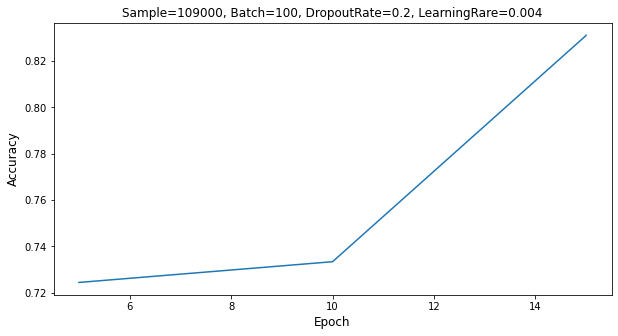

In [44]:
plt.figure(figsize=(10,5))
plt.plot(resultsDF['epoch'], resultsDF['accuracy'])
plt.title('Sample=109000, Batch=100, DropoutRate=0.2, LearningRare=0.004')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.show()

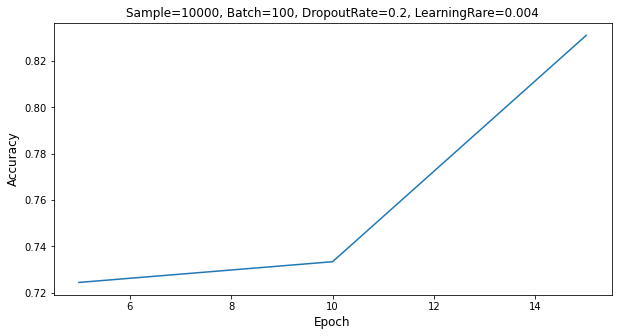

In [45]:
plt.figure(figsize=(10,5))
plt.plot(resultsDF['epoch'], resultsDF['accuracy'])
plt.title('Sample=10000, Batch=100, DropoutRate=0.2, LearningRare=0.004')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.show()

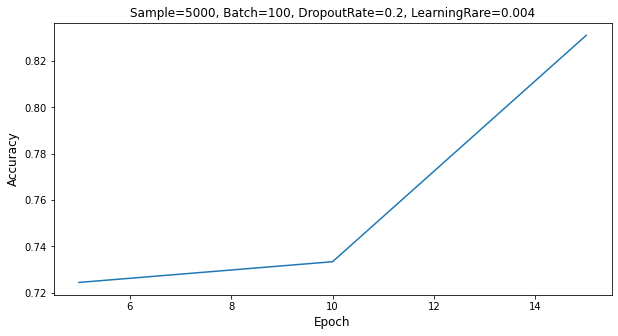

In [46]:
plt.figure(figsize=(10,5))
plt.plot(resultsDF['epoch'], resultsDF['accuracy'])
plt.title('Sample=5000, Batch=100, DropoutRate=0.2, LearningRare=0.004')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.show()

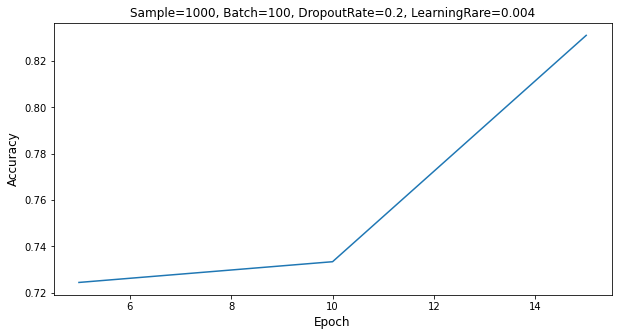

In [47]:
plt.figure(figsize=(10,5))
plt.plot(resultsDF['epoch'], resultsDF['accuracy'])
plt.title('Sample=1000, Batch=100, DropoutRate=0.2, LearningRare=0.004')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.show()

In [51]:
display(resultsDF)

,epoch,dropout,learning,batch,accuracy
0,5,0.2,0.004,100,0.724467
1,10,0.2,0.004,100,0.733413
2,15,0.2,0.004,100,0.831072
